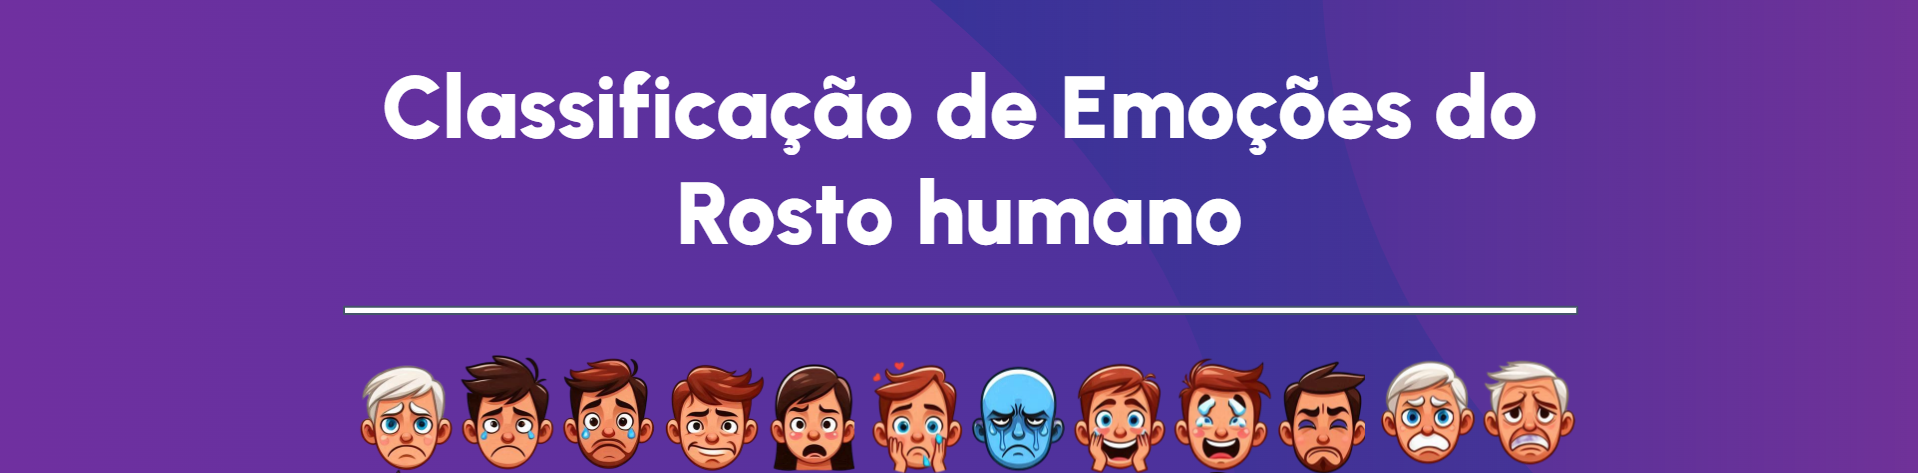


## Bibliotecas e Dependências

In [1]:
!pip install -q opencv-python
!pip install -q torchinfo
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 4.7 MB/s eta 0:00:00


In [2]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import cv2
# import os
# import random
# from tqdm import tqdm

# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
# from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
# from tensorflow.keras import regularizers



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pipeline de dados

### Modulos

In [13]:
from pandas import Series, concat
from os import path, listdir
from numpy.random import randint
import matplotlib.pyplot as plt

def data_path(data_dir):
    data_path = []
    data_labels = []
    folds = listdir(data_dir)

    for fold in folds:
        fold_path = path.join(data_dir, fold)
        files = listdir(fold_path)

        for file in files:
            file_path = path.join(fold_path, file)
            data_path.append(file_path)
            data_labels.append(fold)

    return concat([Series(data_path, name= 'path'),
                   Series(data_labels, name='labels')],
                   axis= 1
    )

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from random import randint

def plot_dataset(dataset, *, num_imagens=16, size=(48, 48)):
    random_index = [randint(0, len(dataset) - 1) for _ in range(num_imagens)]

    fig, axes = plt.subplots(nrows=4,
                             ncols=4,
                             figsize=(10,10),
                             subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        img = Image.open(dataset['path'].iloc[random_index[i]])
        img_gray = img.convert('L')  # Converter para escala de cinza
        img_resized = img_gray.resize(size)  # Redimensionar para 48x48
        ax.imshow(np.array(img_resized), cmap='gray')
        ax.set_title(dataset['labels'].iloc[random_index[i]])

    plt.tight_layout()
    plt.show()





### Dados

In [6]:
dataset_face = data_path('/content/drive/MyDrive/Avant Bootcamp_Base de Dados_Projeto/src/data/data-ready')

In [7]:
dataset_FER2013 = data_path('/content/drive/MyDrive/Avant Bootcamp_Base de Dados_Projeto/src/data/data-test')

In [ ]:
# import random

# row = {'Sad': [0, 1246],
#        'Happy': [1247, 2991],
#        'Angry': [2992, 3949]
# }
# i = []
# for clas, interv in row.items():
#   i.extend(random.sample(range(interv[0], interv[1]), 300))

# print(len(i))

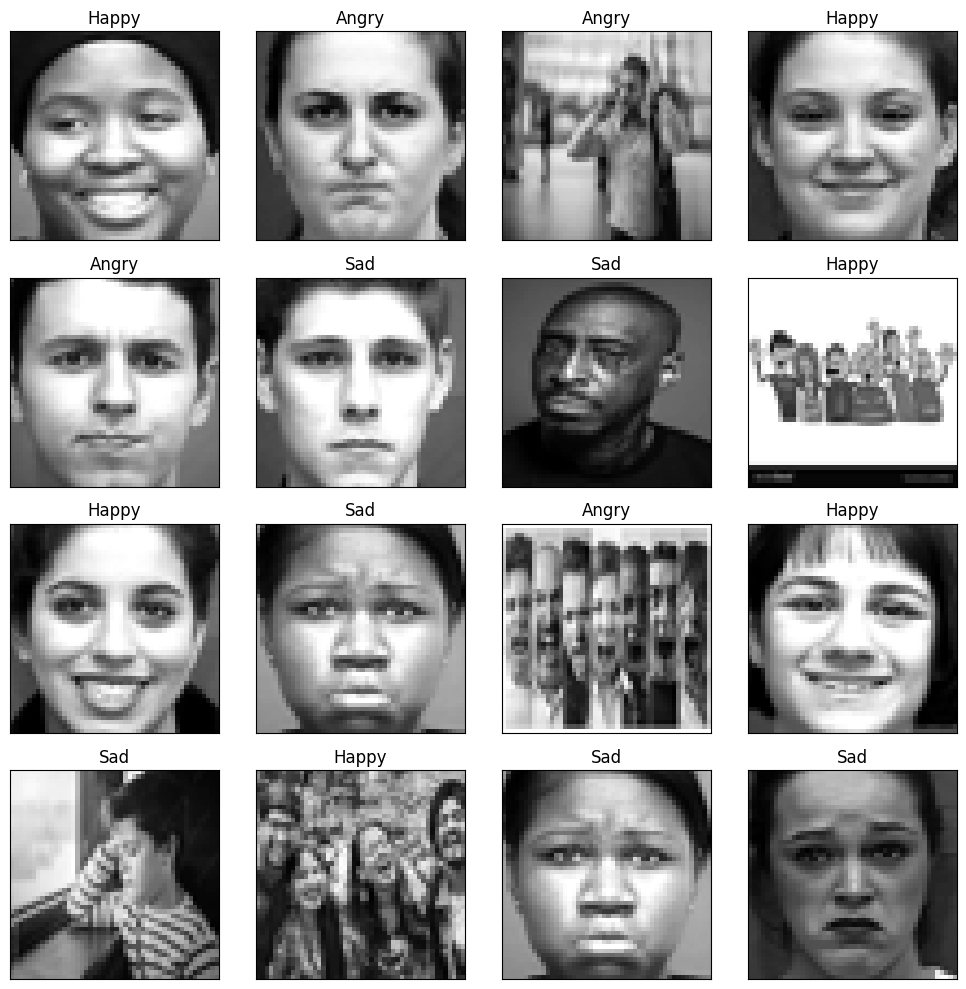

In [16]:
dataset = concat([dataset_face,
                  dataset_FER2013],#.iloc[i]],
                  ignore_index = True
)

plot_dataset(dataset)

In [18]:
dataset.shape

(720, 2)

## Modelo

### Modulos

In [ ]:
# Define uma classe personalizada para carregar imagens e seus respectivos rótulos a partir de um DataFrame
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import torchvision
from torchinfo import summary
import torchmetrics
import torch.optim as optim
import numpy as np
import pandas as pd
from pathlib import Path
import shutil
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

# Função de Treinamento
def train_step(model: torch.nn.Module,
         data_loader: torch.utils.data.DataLoader,
         criterion: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         accuracy_fn: torchmetrics.Accuracy):

    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X, y
        logits = model(X)
        loss = criterion(logits, y)
        train_loss += loss.item()

        preds = logits.argmax(dim = 1)
        train_acc += accuracy_fn(preds, y).item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

# Função de Teste
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              criterion: torch.nn.Module,
              accuracy_fn: torchmetrics.Accuracy):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X, y

            # 1. Forward pass
            test_logits = model(X)

            # 2. Calculate loss and accuracy
            test_loss += criterion(test_logits, y)
            preds = test_logits.argmax(dim = 1)
            test_acc += accuracy_fn(preds, y)

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


### Transfer Learning EfficientNet(ResnetBO)

In [ ]:
from torchvision import models
# Carregamento de Pesos Pré-treinados
weights = models.EfficientNet_B0_Weights.DEFAULT

# Cria o modelo
model = torchvision.models.efficientnet_b0(weights=weights)

In [ ]:
import torchmetrics
# Métrica de Acurácia
accuracy_metric = torchmetrics.Accuracy(task = 'multiclass', num_classes = 3)

In [ ]:
for param in model.features.parameters():
    param.requires_grad = False


In [ ]:
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=3,
                    bias=True))

for param in model.features[8].parameters():
    param.requires_grad = True

summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   Partial
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32

In [ ]:
print(weights)
print((model))

EfficientNet_B0_Weights.IMAGENET1K_V1
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
      

### Divisão dos dados e tratamento dos dados



##### Modulos

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, df, transform = None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.df.loc[idx, 'path']
        image = Image.open(img_path).convert('RGB')
        # gray_image = image.convert('L')
        # image = Image.merge("RGB", (gray_image, gray_image, gray_image))

        label = self.df.loc[idx, 'labels']

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

class DataProcessing:
  def __init__(self, x, y, test_size = None, transf_class = True, auto_transforms = None):
    self._x = x
    self._y = y
    self._test_size = test_size
    self._transf_class = transf_class
    self._auto_transforms = auto_transforms
    self.transforms_class()
    self.split_data()

  @property
  def data_train_test(self):
    return self.data_train, self.data_valid


  def transforms_class(self):
    if self._transf_class:
      label_num = {label: i for i, label in enumerate(self._y.unique())}
      self._y = self._y.map(label_num)
      self._transf_class = False


  def split_data(self, *, shuffle = True, random_state = 42, **kw):
    if self._test_size:
      X_tr, X_val, y_tr, y_val = train_test_split(self._x,
                                                  self._y,
                                                  test_size = self._test_size,
                                                  shuffle = shuffle,
                                                  random_state = random_state,
                                                  **kw
      )

      data_train = pd.concat([X_tr, y_tr], axis = 1).reset_index(drop = True)
      data_valid =  pd.concat([X_val, y_val], axis = 1).reset_index(drop = True)

      self.data_train = CustomImageDataset(data_train, transform = self._auto_transforms)
      self.data_valid = CustomImageDataset(data_valid, transform = self._auto_transforms)

      return self.data_train, self.data_valid

#### Divisão dos dados e tratamento dos dados

In [ ]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Vidisão dos dados entre treino e teste
dataprocessing  = DataProcessing(x = dataset['path'],
                                 y = dataset['labels'],
                                 test_size = 0.2,
                                 auto_transforms = weights.transforms()
)

data_train, data_valid = dataprocessing.data_train_test

In [ ]:
BATCH_SIZE = 32

train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(data_valid, batch_size=BATCH_SIZE)

### Treinamento e validação

In [ ]:
import torchmetrics
# Métrica de Acurácia
accuracy_metric = torchmetrics.Accuracy(task = 'multiclass', num_classes = 3)

In [ ]:
# Define uma classe personalizada para carregar imagens e seus respectivos rótulos a partir de um DataFrame

# Função de Treinamento
def train_step(model: torch.nn.Module,
         data_loader: torch.utils.data.DataLoader,
         criterion: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         accuracy_fn: torchmetrics.Accuracy):

    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X, y
        logits = model(X)
        loss = criterion(logits, y)
        train_loss += loss.item()

        preds = logits.argmax(dim = 1)
        train_acc += accuracy_fn(preds, y).item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

# Função de Teste
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              criterion: torch.nn.Module,
              accuracy_fn: torchmetrics.Accuracy):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X, y

            # 1. Forward pass
            test_logits = model(X)

            # 2. Calculate loss and accuracy
            test_loss += criterion(test_logits, y)
            preds = test_logits.argmax(dim = 1)
            test_acc += accuracy_fn(preds, y)

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


#### Código

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 20
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader = train_loader,
               model = model,
               criterion = criterion,
               optimizer = optimizer,
               accuracy_fn = accuracy_metric
    )
    test_step(data_loader = val_loader,
              model = model,
              criterion = criterion,
              accuracy_fn = accuracy_metric
    )

Epoch: 0
---------
Train loss: 0.16324 | Train accuracy: 0.96%
Test loss: 0.36805 | Test accuracy: 0.85%

Epoch: 1
---------
Train loss: 0.11552 | Train accuracy: 0.98%
Test loss: 0.35697 | Test accuracy: 0.88%

Epoch: 2
---------
Train loss: 0.11365 | Train accuracy: 0.98%
Test loss: 0.34919 | Test accuracy: 0.89%

Epoch: 3
---------
Train loss: 0.09538 | Train accuracy: 0.98%
Test loss: 0.34884 | Test accuracy: 0.89%

Epoch: 4
---------
Train loss: 0.08146 | Train accuracy: 0.98%
Test loss: 0.34467 | Test accuracy: 0.90%

Epoch: 5
---------
Train loss: 0.08590 | Train accuracy: 0.97%
Test loss: 0.34102 | Test accuracy: 0.88%

Epoch: 6
---------
Train loss: 0.06931 | Train accuracy: 0.99%
Test loss: 0.34278 | Test accuracy: 0.89%

Epoch: 7
---------
Train loss: 0.05264 | Train accuracy: 0.99%
Test loss: 0.32460 | Test accuracy: 0.88%

Epoch: 8
---------
Train loss: 0.03821 | Train accuracy: 0.99%
Test loss: 0.31804 | Test accuracy: 0.87%

Epoch: 9
---------
Train loss: 0.04278 | Train

## Oportunidades de Melhoria


1.   **Limpeza dos Dados:**

  *   **Descrição**: remover as imagens duplicadas e de baixa qualidade pode melhorar  a qualidade do conjunto de dados.

  *   **Impacto:** manter as imagens duplicadas e de baixa qualidade pode introduzir ruído e confundir o modelo, reduzindo assim a acurácia. Limpar o conjunto de dados pode ajudar o modelo a aprender padrões mais relevantes e generalizar melhor para novos dados.


2.   **Ampliar o Conjunto de Dados:**

  *   **Descrição:** incluir mais imagens em diferentes cenários e contextos pode enriquecer o conjunto de dados com uma visão mais completa da diversidade de emoções faciais.
    *   **Impacto:** um conjunto de dados mais amplo pode ajudar o modelo a aprender a distinguir melhor entre diferentes emoções, o que pode melhorar a acurácia geral.


3.  **Balanceamento das Classes:**

  *   **Descrição:** equilibrar a quantidade de imagens entre as classes menos representadas pode prevenir o viés do modelo em favor das classes mais comuns.
  *   **Impacto:** quando o conjunto de dados é desequilibrado, o modelo pode se tornar enviesado em relação às classes mais frequentes. Balancear as classes pode levar a uma melhoria na acurácia das classes menos representadas e proporcionar uma avaliação mais justa do desempenho do modelo.


4.   **Redução na Dimensão das Imagens:**

  *   **Descrição:** ajustar a dimensão das imagens pode ajudar a reduzir o tempo de treinamento e melhorar a eficiência do modelo sem comprometer a qualidade dos dados.
  *  **Impacto:** Imagens de alta resolução podem aumentar o tempo de treinamento e os requisitos computacionais. Reduzir a dimensão das imagens para um tamanho adequado pode acelerar o treinamento no modelo.
